In [1]:
import time
from pathlib import Path
from io import BytesIO

import torch
from captum.attr import LRP

from gtp.dataloading.tools import (
    collect_chromosome,
    collect_chromosome_position_metadata,
)
import numpy as np
import pandas as pd
from PIL import Image, ImageChops
from matplotlib import cm

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.path_collectors import (
    get_experiment_directory,
    get_post_processed_genotype_directory,
    get_post_processed_phenotype_directory,
    get_results_training_metadata_directory,
)
from gtp.models.net import SoyBeanNet
from gtp.options.process_attribution import ProcessAttributionOptions

config_path = Path("../configs/default.yaml")
cfgs: GenotypeToPhenotypeConfigs = load_configs(config_path)
opts: ProcessAttributionOptions = ProcessAttributionOptions(
    drop_out_prob=0.75,
    out_dims=1,
    out_dims_start_idx=0,
    insize=3,
    hidden_dim=10,
    species="erato",
    chromosome=18,
    color="color_3",
    wing="forewings",
    exp_name="base",
)


def get_camids(species):
    metadata_dir = get_results_training_metadata_directory(cfgs.io)
    train_camids = np.load(metadata_dir / f"{species}_train.npy").tolist()
    val_camids = np.load(metadata_dir / f"{species}_val.npy").tolist()
    test_camids = np.load(metadata_dir / f"{species}_test.npy").tolist()
    camids = train_camids + val_camids + test_camids

    return camids


def get_proj_matrix(species, wing, color):
    proj_matrices_dir = Path(cfgs.io.default_root, "dna/projection_matrices")
    pca_df = pd.read_csv(proj_matrices_dir / f"{species}_{wing}_{color}.csv")
    pca_w = pca_df.to_numpy()
    return pca_w


def create_proj_img_bytes(pca_w, pca_vector):
    proj_img_m = pca_w @ pca_vector.T
    proj_img_m = proj_img_m.reshape(300, 300)  # Range between [-1, 1]
    proj_img_m -= -1
    proj_img_m /= 2
    im = Image.fromarray(
        np.uint8(
            cm.bwr(
                proj_img_m,
            )
            * 255
        )
    )

    im_bytes = BytesIO()
    im.save(im_bytes, format="PNG")
    return im_bytes


def get_proj_img(species, wing, color, camid):
    phenotype_folder = get_post_processed_phenotype_directory(cfgs.io)
    pca_df = pd.read_csv(phenotype_folder / f"{species}_{wing}_{color}" / "data.csv")
    results = pca_df.loc[pca_df.camid == camid]
    pca_vector = results.iloc[:1, 1:].to_numpy()
    pca_w = get_proj_matrix(species, wing, color)

    im_bytes = create_proj_img_bytes(pca_w, pca_vector)

    return im_bytes


def get_model_proj_img(species, wing, color, camid, pca_edit_vec, start_idx):
    phenotype_folder = get_post_processed_phenotype_directory(cfgs.io)
    pca_df = pd.read_csv(phenotype_folder / f"{species}_{wing}_{color}" / "data.csv")
    results = pca_df.loc[pca_df.camid == camid]
    pca_vector = results.iloc[:1, 1:].to_numpy()
    pca_vector[0][start_idx : len(pca_edit_vec)] = pca_edit_vec
    pca_w = get_proj_matrix(species, wing, color)

    im_bytes = create_proj_img_bytes(pca_w, pca_vector)

    return im_bytes


def get_genes(species, chromosome, camid):
    # Get gene states
    genotype_folder = get_post_processed_genotype_directory(cfgs.io)
    genotype_folder = genotype_folder / cfgs.experiment.genotype_scope
    genotype_camids, genotype_data = collect_chromosome(
        genotype_folder, species, chromosome
    )
    loc = np.where(genotype_camids == camid)[0][0]
    genotype_data_short = (genotype_data[loc] * [0, 1, 2]).sum(-1)
    string_genes = np.empty(genotype_data_short.shape[0], dtype="<U10")
    string_genes[genotype_data_short == 0] = "aa"  # Recessive
    string_genes[genotype_data_short == 1] = "Aa/aA"  # heterogeneous
    string_genes[genotype_data_short == 2] = "AA"  # Dominant

    # Get Position Metadata
    position_metadata = collect_chromosome_position_metadata(
        genotype_folder,
        species,
        chromosome,
    )

    pos_strs = [f"{x[0]}:{x[1]}" for x in position_metadata]

    assert string_genes.shape[0] == len(pos_strs), "Error in alignment"
    rv = [f"{x[0]} ({x[1]})" for x in zip(pos_strs, string_genes)]
    return rv, genotype_data[loc]


def load_model(species, wing, color, chromosome, camid):
    start = time.time()
    gene_input = (
        torch.tensor(get_genes(species, chromosome, camid)[1]).unsqueeze(0).unsqueeze(0)
    )
    num_vcfs = gene_input[0].shape[1]
    model = SoyBeanNet(
        window_size=num_vcfs,
        num_out_dims=opts.out_dims,
        insize=opts.insize,
        hidden_dim=opts.hidden_dim,
        drop_out_prob=opts.drop_out_prob,
    )

    experiment_dir = get_experiment_directory(
        cfgs.io,
        species=species,
        wing=wing,
        color=color,
        chromosome=chromosome,
        exp_name=opts.exp_name,
    )

    model.load_state_dict(torch.load(experiment_dir / "model.pt", weights_only=True))
    model = model.cuda()
    model.eval()

    end = time.time()
    print(f"Time to load the model: {end - start}")
    return model


def get_lrp_attr_single(model, x, target=0):
    att_model = LRP(model)
    model.zero_grad()
    x.requires_grad = True
    attr = att_model.attribute(x.cuda(), target=target)
    # For LRP, this (ONE-HOT state ex. [0,0,1] attributions) should be sum.
    # This is because the attribution scores should all add up to be the find value in the prediction, so averaging could break that.
    attr = attr.sum(-1)
    attr = attr[0, 0]  # Only has 1 channel, just extract it and is one batch item
    attr = attr.detach().cpu().numpy()

    return attr


test_wing = "forewings"
test_species = "erato"
test_color = "color_3"
test_chromosome = 18
test_camid = "CAM016634"
# gene_str, gene_ml = get_genes(test_species, test_chromosome, test_camid)
##
# m = load_model(test_species, test_wing, test_color, test_chromosome, test_camid)
# m = m.cuda()
# get_lrp_attr_single(m, torch.tensor(gene_ml).unsqueeze(0).unsqueeze(0).float().cuda())

Time to load the model: 7.686217308044434
Time to use the model: 0.006190299987792969


GridspecLayout(children=(Dropdown(description='Species', layout=Layout(grid_area='widget001'), options=('erato…

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x84\x00\x00\x01,\x08\x06\x00\x00\x00\x9b\x9e}\x9…

GridspecLayout(children=(HTML(value='<b>Original Projection</b>', layout=Layout(grid_area='widget001')), HTML(…

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x01,\x08\x06\x…

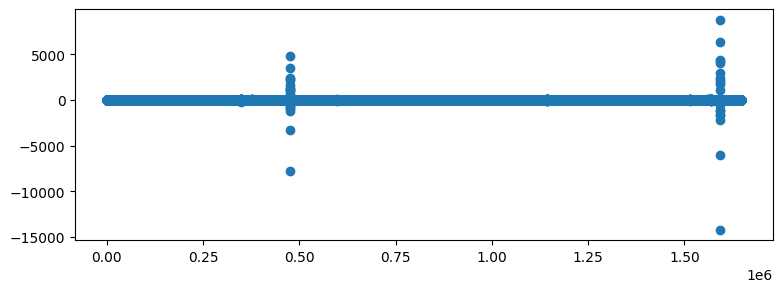

Time to load the model: 8.081995487213135


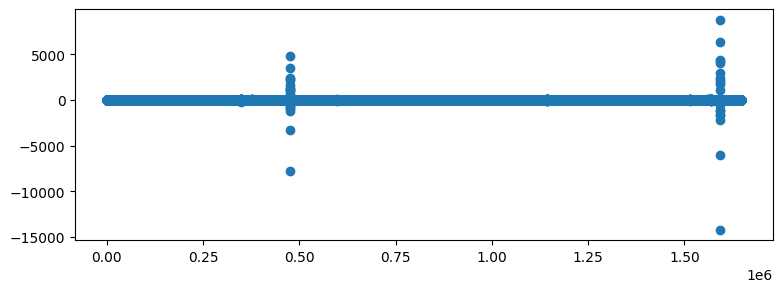

Time to load the model: 5.885529518127441


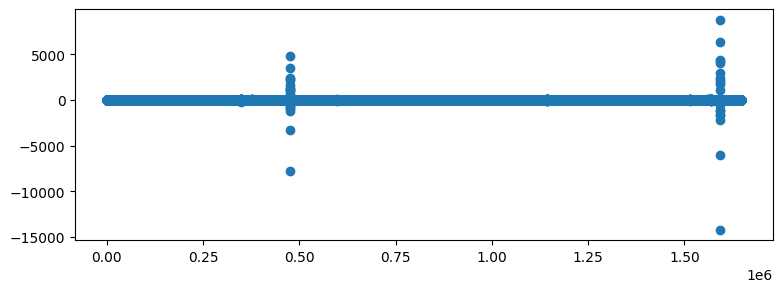

In [ ]:
import ipywidgets as widgets
import time

import matplotlib.pyplot as plt

species_dd = widgets.Dropdown(
    options=["erato", "melpomene"],
    value="erato",
    description="Species",
    disabled=False,
)

wing_dd = widgets.Dropdown(
    options=["forewings", "hindwings"],
    value="forewings",
    description="Wing",
    disabled=False,
)

color_dd = widgets.Dropdown(
    options=["color_1", "color_2", "color_3", "total"],
    value="color_3",
    description="Color",
    disabled=False,
)

chromosome_box = widgets.BoundedIntText(
    value=18, min=1, max=21, step=1, description="Chromosome:", disabled=False
)

init_camids = get_camids("erato")
camid_dd = widgets.Dropdown(
    options=init_camids,
    value=init_camids[0],
    description="CAMID",
    disabled=False,
)

proj_img = widgets.Image(
    value=get_proj_img(
        species="erato", wing="forewings", color="color_3", camid=init_camids[0]
    ).getvalue(),
    format="png",
)

model = load_model("erato", "forewings", "color_3", 18, init_camids[0])

init_gene_strs, init_gene_ml = get_genes("erato", 18, init_camids[0])
gene_input = torch.tensor(init_gene_ml).unsqueeze(0).unsqueeze(0).float().cuda()
init_attr = get_lrp_attr_single(model, gene_input)
attr_order = np.argsort(init_attr)[::-1]

start = time.time()
output = model(gene_input)[0].detach().cpu().numpy()
last_output = output
end = time.time()
print(f"Time to use the model: {end - start}")


model_proj_bytes = get_model_proj_img(
    "erato", "forewings", "color_3", init_camids[0], output, opts.out_dims_start_idx
).getvalue()

model_proj_img = widgets.Image(
    value=model_proj_bytes,
    format="png",
)

edit_model_proj_img = widgets.Image(
    value=model_proj_bytes,
    format="png",
)

zero_img = Image.fromarray(np.zeros((300, 300)).astype(np.uint8))
zero_img_bytes = BytesIO()
zero_img.save(zero_img_bytes, format="PNG")

diff_edit_model_proj_img = widgets.Image(
    value=zero_img_bytes.getvalue(),
    format="png",
)


def get_base_values():
    return species_dd.value, wing_dd.value, color_dd.value, chromosome_box.value


def update_camids(*args):
    camids = get_camids(species_dd.value)
    camid_dd.options = camids
    camid_dd.value = camids[0]


fig, ax = plt.subplots(1, 1, figsize=(9, 3))
ax.scatter(np.arange(len(init_gene_strs)), init_attr)
buf = BytesIO()
fig.savefig(buf, format="png")

attribution_plot = widgets.Image(
    value=buf.getvalue(),
    format="png",
)


def update_proj_img(*args):
    attribution_plot.layout.visibility = "hidden"
    proj_img.layout.visibility = "hidden"
    model_proj_img.layout.visibility = "hidden"
    species, wing, color, chromosome = get_base_values()
    camid = camid_dd.value
    proj_bytes = get_proj_img(
        species=species, wing=wing, color=color, camid=camid
    ).getvalue()
    proj_img.value = proj_bytes
    proj_img.layout.visibility = "visible"

    model = load_model(species, wing, color, chromosome, camid)
    gene_input = (
        torch.tensor(get_genes(species, chromosome, camid)[1])
        .unsqueeze(0)
        .unsqueeze(0)
        .float()
    )

    output = model(gene_input.cuda())[0].detach().cpu().numpy()
    last_output = output
    model_proj_bytes = get_model_proj_img(
        species, wing, color, camid, output, opts.out_dims_start_idx
    ).getvalue()
    model_proj_img.value = model_proj_bytes
    model_proj_img.layout.visibility = "visible"

    edit_model_proj_img.value = model_proj_bytes
    diff_edit_model_proj_img.value = zero_img_bytes.getvalue()

    fig, ax = plt.subplots(1, 1, figsize=(9, 3))
    ax.scatter(np.arange(len(init_gene_strs)), init_attr)
    buf = BytesIO()
    fig.savefig(buf, format="png")

    attribution_plot.value = buf.getvalue()
    attribution_plot.layout.visibility = "visible"


species_dd.observe(update_camids, "value")
species_dd.observe(update_proj_img, "value")
wing_dd.observe(update_proj_img, "value")
color_dd.observe(update_proj_img, "value")
camid_dd.observe(update_proj_img, "value")

display_genes = [
    f"{init_gene_strs[idx]} {round(init_attr[idx], 2)}" for idx in attr_order[:50]
]

gene_selection_dd = widgets.Dropdown(
    options=display_genes,
    value=display_genes[0],
    description="Gene",
    disabled=False,
)


def update_gene_selection(*args):
    species, wing, color, chromosome = get_base_values()
    genes_str, genes_ml = get_genes(species, chromosome, camid_dd.value)
    init_attr = get_lrp_attr_single(model, gene_input)
    attr_order = np.argsort(init_attr)[::-1]
    display_genes = [
        f"{genes_str[idx]} {round(init_attr[idx], 2)}" for idx in attr_order[:50]
    ]
    gene_selection_dd.options = display_genes[:50]
    gene_selection_dd.value = display_genes[0]


species_dd.observe(update_gene_selection, "value")
chromosome_box.observe(update_gene_selection, "value")
camid_dd.observe(update_gene_selection, "value")

init_gene_str = display_genes[0].split(" ")[1][1:-1]
gene_edit_selection_dd = widgets.Dropdown(
    options=["AA", "Aa/aA", "aa"],
    value=init_gene_str,
    description="Gene Edit:",
    disabled=False,
)

diff_img = None


def update_model_edit_proj_img(*args):
    edit_model_proj_img.layout.visibility = "hidden"
    diff_edit_model_proj_img.layout.visibility = "hidden"
    species, wing, color, chromosome = get_base_values()
    camid = camid_dd.value
    model = load_model(species, wing, color, chromosome, camid)
    gene_input = (
        torch.tensor(get_genes(species, chromosome, camid)[1])
        .unsqueeze(0)
        .unsqueeze(0)
        .float()
    )

    edit_vec = None
    edit_gene_str = gene_edit_selection_dd.value
    if edit_gene_str == "AA":
        edit_vec = torch.tensor([0, 0, 1])
    elif edit_gene_str == "aa":
        edit_vec = torch.tensor([1, 0, 0])
    else:
        edit_vec = torch.tensor([0, 1, 0])

    loc = attr_order[gene_selection_dd.options.index(gene_selection_dd.value)]
    gene_input[0][0][loc] = edit_vec

    output = model(gene_input.cuda())[0].detach().cpu().numpy()
    print(f"Output diff: {last_output - output}")
    edit_model_proj_bytes = get_model_proj_img(
        species, wing, color, camid, output, opts.out_dims_start_idx
    ).getvalue()
    edit_model_proj_img.value = edit_model_proj_bytes

    model_img = Image.open(BytesIO(model_proj_img.value))
    edit_model_img = Image.open(BytesIO(edit_model_proj_bytes))

    diff_img = (np.array(model_img) - np.array(edit_model_img)).astype(np.float64)
    print(diff_img[:10, :10, 0])
    diff_img = diff_img.sum(-1)
    diff_img -= diff_img.min()
    diff_img /= diff_img.max()

    diff_img = Image.fromarray(
        np.uint8(
            cm.bwr(
                diff_img,
            )
            * 255
        )
    )
    diff_bytes = BytesIO()
    diff_img.save(diff_bytes, format="png")
    diff_edit_model_proj_img.value = diff_bytes.getvalue()

    diff_edit_model_proj_img.layout.visibility = "visible"
    edit_model_proj_img.layout.visibility = "visible"


gene_edit_selection_dd.observe(update_model_edit_proj_img, "value")

grid = widgets.GridspecLayout(4, 2)
grid[0, 0] = species_dd
grid[0, 1] = wing_dd
grid[1, 0] = color_dd
grid[1, 1] = chromosome_box
grid[2, 0] = camid_dd
grid[2, 1] = gene_selection_dd
grid[3, 0] = gene_edit_selection_dd

caption_grid = widgets.GridspecLayout(1, 4)
caption_grid[0, 0] = widgets.HTML(value="<b>Original Projection</b>")
caption_grid[0, 1] = widgets.HTML(value="<b>Model Projection</b>")
caption_grid[0, 2] = widgets.HTML(value="<b>Edited Projection</b>")
caption_grid[0, 3] = widgets.HTML(value="<b>Difference</b>")

img_grid = widgets.GridspecLayout(1, 4)
img_grid[0, 0] = proj_img
img_grid[0, 1] = model_proj_img
img_grid[0, 2] = edit_model_proj_img
img_grid[0, 3] = diff_edit_model_proj_img

display(grid)
display(attribution_plot)
display(caption_grid)
display(img_grid)


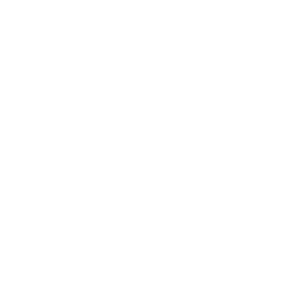

In [8]:
Image.open(BytesIO(diff_edit_model_proj_img.value))